# Visualizations For Infographic

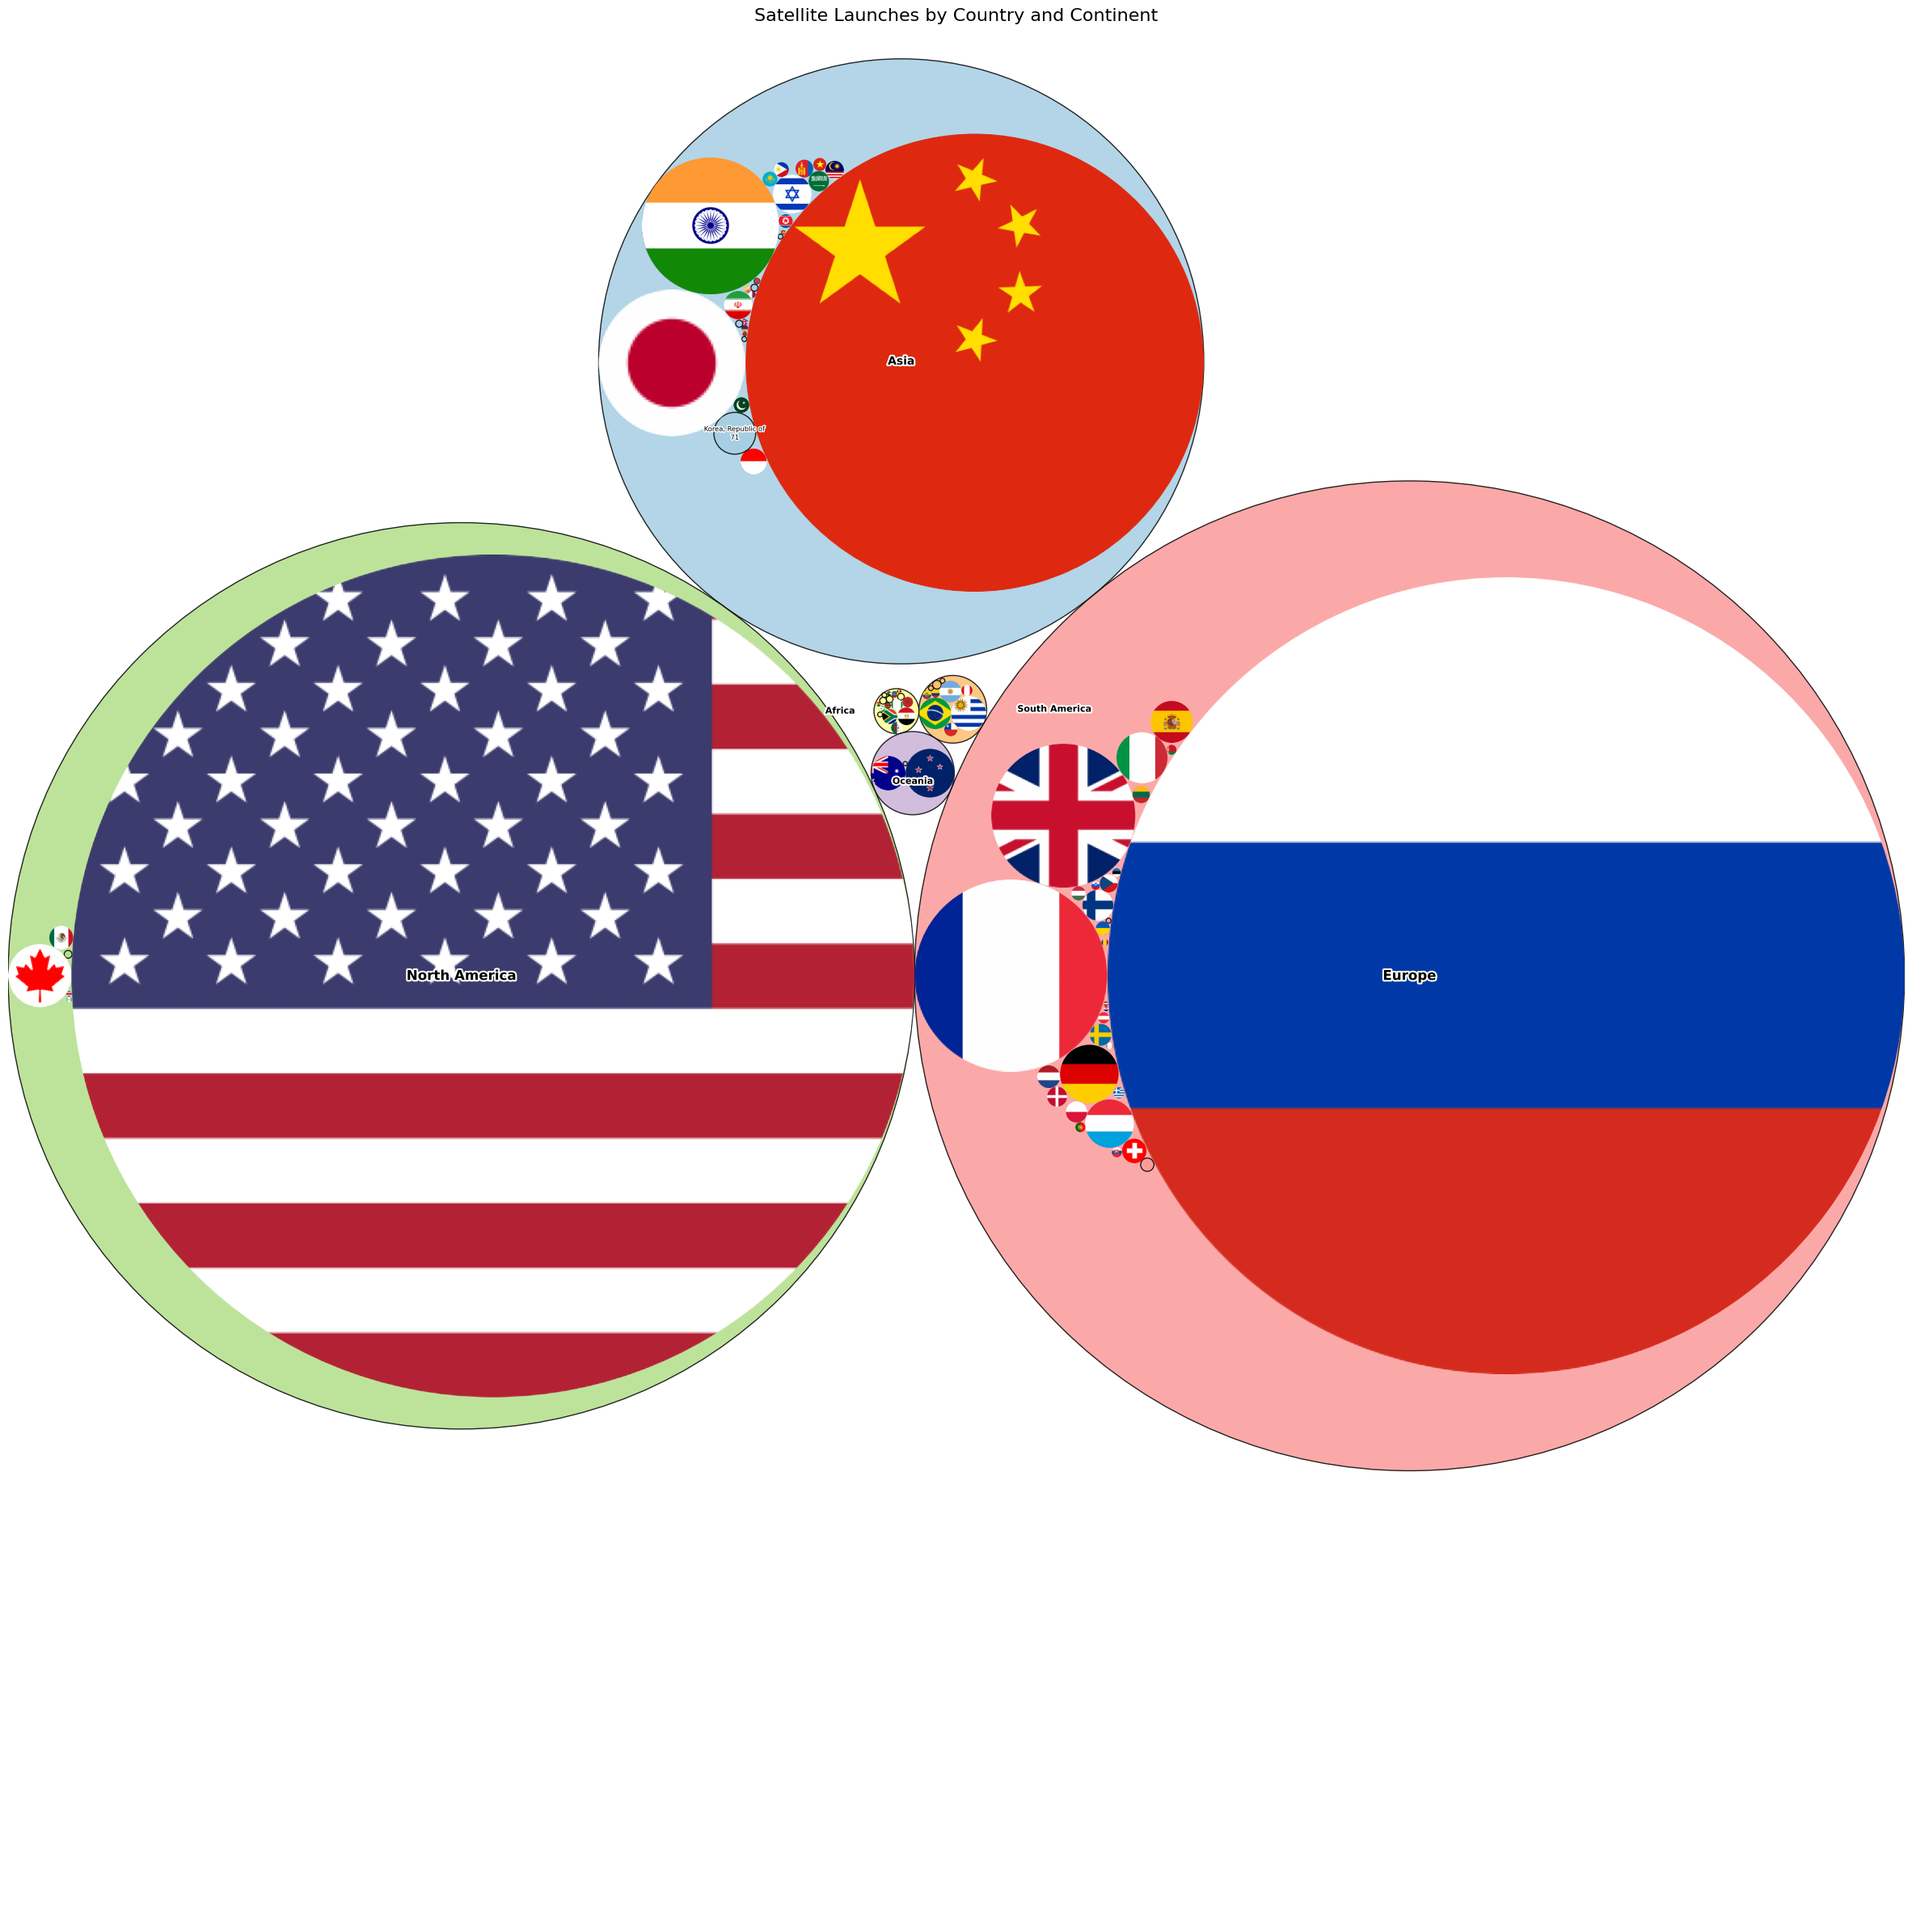

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import circlify
import pycountry
import matplotlib.patheffects as pe
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import os
import logging
import warnings

logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.font_manager')

satcat = pd.read_csv("satcat.tsv", sep="\t", low_memory=False)
satcat.loc[satcat['State'] == 'SU', 'State'] = 'RU'

manual_country_map = {
    'UK': 'United Kingdom', 'D': 'Germany', 'E': 'Spain', 'F': 'France',
    'I': 'Italy', 'J': 'Japan', 'L': 'Luxembourg', 'P': 'Portugal',
    'S': 'Sweden', 'RU': 'Russia', 'CSFR': 'Czech Republic', 'CSSR': 'Czech Republic',
    'HKUK': 'United Kingdom', 'MYM': 'Malaysia', 'BGN': 'Bulgaria',
    'CYM': 'United Kingdom', '-': 'Unknown'
}
code_to_name = {country.alpha_2: country.name for country in pycountry.countries}
code_to_name.update(manual_country_map)

satcat['Country'] = satcat['State'].map(code_to_name)
satcat_clean = satcat.dropna(subset=['Country'])
launch_counts = satcat_clean['Country'].value_counts().to_dict()

if 'Russia' in launch_counts:
    launch_counts['Russian Federation'] = launch_counts['Russia']

world = gpd.read_file("ne_110m_admin_0_countries.shp")
world = world[['ADMIN', 'CONTINENT']]
world.columns = ['Country', 'Continent']

corrections = {
    "United States of America": "United States",
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "North Korea": "Korea, Democratic People's Republic of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Vietnam": "Viet Nam",
    "Laos": "Lao People's Democratic Republic",
    "Bolivia": "Bolivia, Plurinational State of",
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Tanzania": "Tanzania, United Republic of",
    "Brunei": "Brunei Darussalam",
    "Moldova": "Moldova, Republic of",
}
world['Country'] = world['Country'].replace(corrections)

world.loc[world['Country'] == 'Russian Federation', 'Continent'] = 'Europe'

world['Launches'] = world['Country'].map(launch_counts)
world = world.dropna(subset=['Launches'])

children = []
for continent in world['Continent'].unique():
    df = world[world['Continent'] == continent]
    countries = [{'id': row['Country'], 'datum': row['Launches']} for _, row in df.iterrows()]
    total = sum(c['datum'] for c in countries)
    children.append({'id': continent, 'datum': total, 'children': countries})

nested_data = {'id': 'World', 'children': children}

circles = circlify.circlify(
    nested_data['children'],
    show_enclosure=True,
    target_enclosure=circlify.Circle(x=0, y=0, r=1),
)

def normalize_country_name(name):
    name = name.lower()
    for phrase in [
        "republic of", "plurinational state of", "islamic republic of",
        "democratic people's republic of", "people's democratic republic",
        "united republic of", "bolivarian republic of"
    ]:
        name = name.replace(phrase, "")
    name = name.replace(",", "").replace(" ", "_").strip("_")
    return name

def load_flag(country_name):
    manual_map = {
        "Korea, Republic of": "south_korea.png",
        "Korea, Democratic People's Republic of": "north_korea.png",
        "Iran, Islamic Republic of": "iran.png",
        "Russia": "russia.png",
        "Russian Federation": "russia.png",
        "United States": "united_states.png"
    }
    path = f"flags/{manual_map.get(country_name, normalize_country_name(country_name) + '.png')}"
    return mpimg.imread(path) if os.path.exists(path) else None

def draw_flag_circle(ax, img, x, y, r):
    extent = [x - r, x + r, y - r, y + r]
    im = ax.imshow(img, extent=extent, zorder=1)
    clip = Circle((x, y), r, transform=ax.transData)
    im.set_clip_path(clip)

fig, ax = plt.subplots(figsize=(36, 24))
ax.axis('off')
lim = max(abs(c.x) + c.r for c in circles)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

continent_colors = {
    'Asia': '#A6CEE3', 'North America': '#B2DF8A', 'Europe': '#FB9A99',
    'South America': '#FDBF6F', 'Oceania': '#CAB2D6', 'Africa': '#FFFF99'
}

for c in circles:
    if c.ex is None:
        continue

    x, y, r = c.x, c.y, c.r
    label = c.ex['id']
    level = c.level
    datum = c.ex.get('datum', 0)
    continent = None

    if level == 2:
        for cont in children:
            if any(ctry['id'] == label for ctry in cont['children']):
                continent = cont['id']
                break
    elif level == 1:
        continent = label

    facecolor = continent_colors.get(continent, '#dddddd')

    if level == 1:
        ax.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='black'))
        label_offsets = {
            'Africa': (-r * 2.5, 0),
            'Oceania': (0, -r * 0.2),
            'South America': (r * 3, 0),
        }
        dx, dy = label_offsets.get(label, (0, 0))
        font_size = 12 if r > 0.4 else (10 if r > 0.25 else 8)
        ax.text(x + dx, y + dy, label, ha='center', va='center', fontsize=font_size, fontweight='bold',
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])
    elif level == 2:
        flag_img = load_flag(label)
        if flag_img is not None:
            draw_flag_circle(ax, flag_img, x, y, r)
            continue
        ax.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='black'))
        if datum >= 60:
            ax.text(x, y, f"{label}\n{int(datum)}", ha='center', va='center', fontsize=6,
                    path_effects=[pe.withStroke(linewidth=2, foreground="white")])

plt.title("Satellite Launches by Country and Continent", fontsize=16)
plt.tight_layout()
plt.show()

In [2]:
import pandas as pd
import plotly.graph_objects as go
import pycountry

satcat_data = pd.read_csv('satcat.tsv', sep='\t', low_memory=False)

satcat_data.loc[satcat_data['State'] == 'SU', 'State'] = 'RU'

manual_country_map = {
    'UK': 'United Kingdom',
    'D': 'Germany',
    'E': 'Spain',
    'F': 'France',
    'I': 'Italy',
    'J': 'Japan',
    'L': 'Luxembourg',
    'P': 'Portugal',
    'S': 'Sweden',
    'RU': 'Russia',
    'CSFR': 'Czech Republic',
    'CSSR': 'Czech Republic',
    'HKUK': 'United Kingdom',
    'MYM': 'Malaysia',
    'BGN': 'Bulgaria',
    'CYM': 'United Kingdom',
    '-': 'Unknown'
}

country_acronyms_full = {country.alpha_2: country.name for country in pycountry.countries}
country_acronyms_full.update(manual_country_map)

satcat_data['Country'] = satcat_data['State'].map(country_acronyms_full)
satcat_data_clean = satcat_data.dropna(subset=['Country'])

launch_counts_by_country = satcat_data_clean['Country'].value_counts().reset_index(name="Launch_Count")
launch_counts_by_country.columns = ['Country', 'Launch_Count']

top5 = launch_counts_by_country.nlargest(5, 'Launch_Count')

african_country_codes = ['DZ','AO','BJ','BW','BF','BI','CM','CV','CF','TD','KM','CG','CD','DJ','EG','GQ','ER',
                         'SZ','ET','GA','GM','GH','GN','GW','CI','KE','LS','LR','LY','MG','MW','ML','MR','MU',
                         'MA','MZ','NA','NE','NG','RW','ST','SN','SC','SL','SO','ZA','SS','SD','TZ','TG','TN',
                         'UG','ZM','ZW']
all_countries = set([country.name for country in pycountry.countries])
launched_countries = set(launch_counts_by_country['Country'])

african_no_launch = [country.name for country in pycountry.countries 
                     if country.alpha_2 in african_country_codes and country.name not in launched_countries]

african_no_launch_count = len(african_no_launch)
total_african_countries = len(african_country_codes)
african_no_launch_percentage = african_no_launch_count / total_african_countries * 100

if 'Russia' in launch_counts_by_country['Country'].values:
    russia_total = launch_counts_by_country.loc[
        launch_counts_by_country['Country'] == 'Russia', 'Launch_Count'
    ].values[0]
else:
    russia_total = 0

fig = go.Figure(data=go.Choropleth(
    locations=launch_counts_by_country['Country'],
    locationmode='country names',
    z=launch_counts_by_country['Launch_Count'],
    colorscale='YlOrRd',
    colorbar_title='Launches',
    zmin=0,
    zmax=launch_counts_by_country['Launch_Count'].max(),
    marker_line_color='black',
))

fig.update_layout(
    title={
        'text': "Satellite Launch Heatmap by Country (2010–2023)<br>"
                "<sup>USA, China, and Russia (incl. USSR) dominate launches; much of Africa remains absent.</sup>",
        'x': 0.5,
        'xanchor': 'center',
        'font': dict(size=22)
    },
    geo=dict(
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="lightblue",
        showcoastlines=True,
        coastlinecolor="white",
        projection_type="natural earth"
    ),
    margin=dict(l=30, r=30, t=120, b=120),
    font=dict(size=12),
    paper_bgcolor="white"
)

fig.add_annotation(
    text="🇺🇸 USA: <b>23,350</b> launches",
    x=0.11, y=0.75,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderpad=3
)

fig.add_annotation(
    text=f"🇷🇺 Russia (incl. USSR): <b>{russia_total:,}</b> launches",
    x=1, y=0.95,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderpad=3
)

fig.add_annotation(
    text="🇨🇳 China: <b>8,536</b> launches",
    x=0.9, y=0.75,
    xref="paper", yref="paper",
    showarrow=False,
    font=dict(size=12),
    bgcolor="white",
    bordercolor="black",
    borderpad=3
)

fig.add_annotation(
    text=f"🌍 {african_no_launch_count}/54 African countries (~{african_no_launch_percentage:.1f}%) had zero launches.",
    xref="paper", yref="paper",
    x=0.5, y=-0.12,
    showarrow=False,
    font=dict(size=11, color="darkred"),
    align="center",
    bgcolor="white",
    bordercolor="darkred",
    borderwidth=1,
    borderpad=4
)

fig.add_annotation(
    text="Source: Satellite Catalog (2010–2023)",
    xref="paper", yref="paper",
    x=0.5, y=-0.2,
    showarrow=False,
    font=dict(size=10),
    align="center"
)

fig.show()

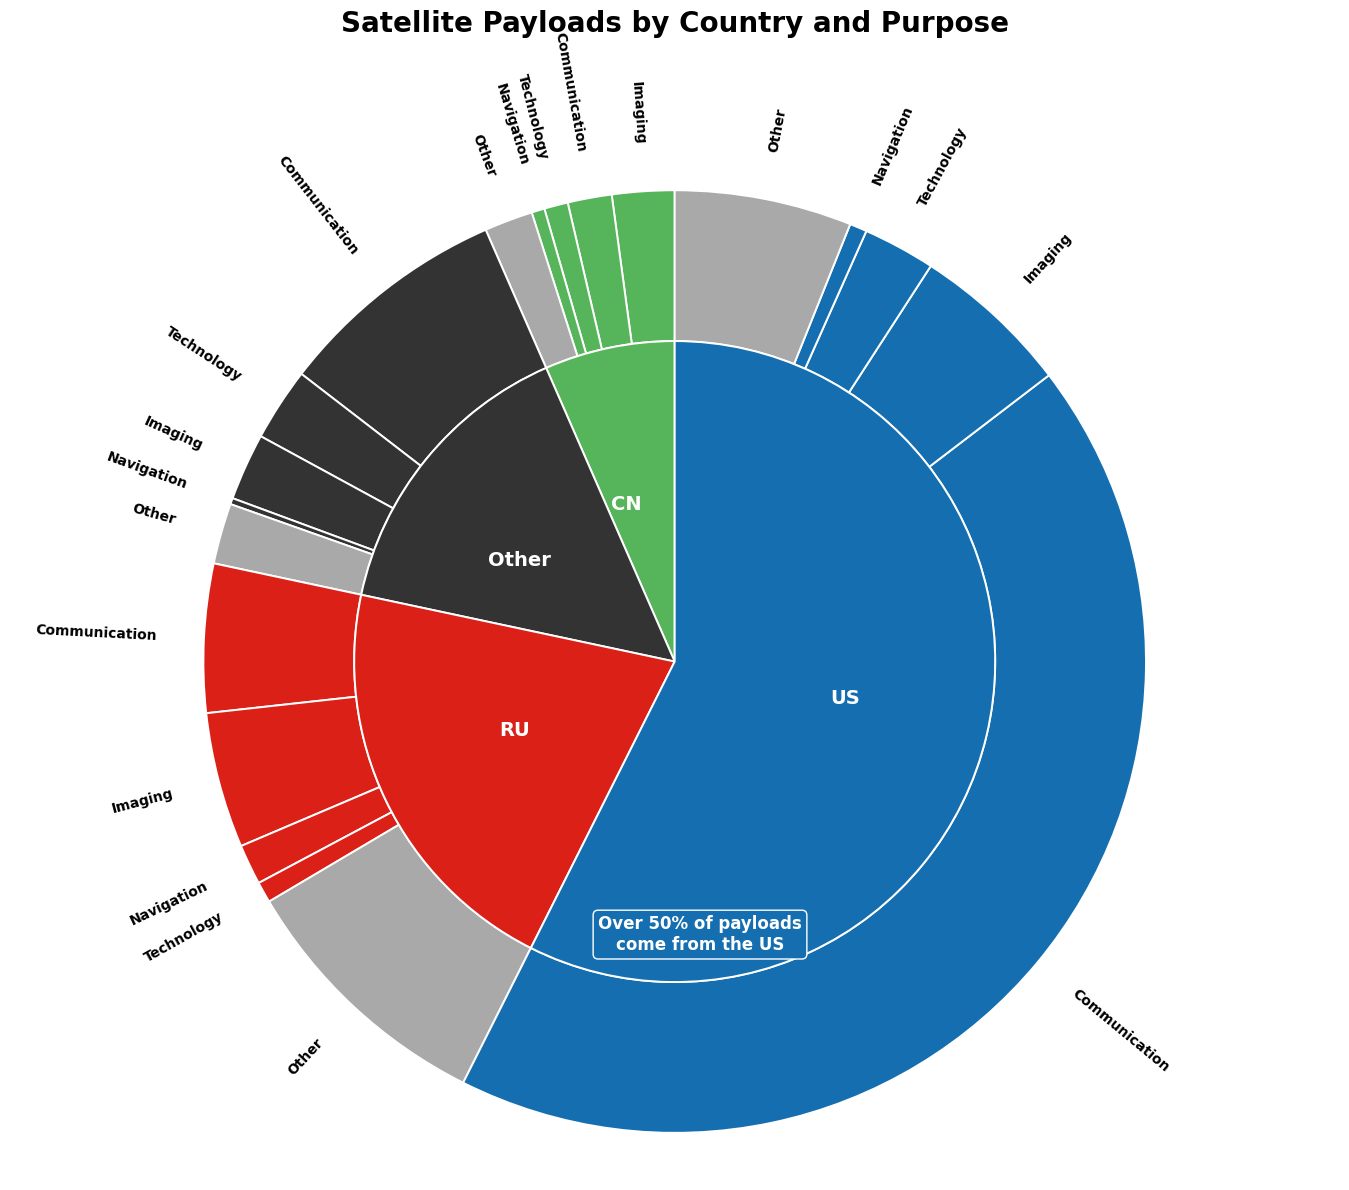

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

def pie_chart_with_annotations():
    df_sat = pd.read_csv('satcat.tsv', sep='\t', low_memory=False)
    df_cat = pd.read_csv('psatcat.tsv', sep='\t', low_memory=False)
    
    df_sat = df_sat[df_sat['Type'].str.startswith('P', na=False)].copy()
    
    df_cat['#JCAT'] = df_cat['#JCAT'].astype(str)
    df_sat['#JCAT'] = df_sat['#JCAT'].astype(str)
    
    merged_df = pd.merge(df_sat, df_cat[['#JCAT', 'Category']], on='#JCAT', how='left')
    merged_df['State'] = merged_df['State'].replace({'SU': 'RU'})
    merged_df = merged_df.dropna(subset=['Category'])
    
    def simplify_category(cat):
        if 'COM' in cat: return 'Communication'
        elif 'IMG' in cat: return 'Imaging'
        elif 'NAV' in cat: return 'Navigation'
        elif 'TECH' in cat: return 'Technology'
        else: return 'Other'
    
    merged_df['Category'] = merged_df['Category'].astype(str).apply(simplify_category)
    
    top_countries = ['US', 'RU', 'CN']
    merged_df['CountryGroup'] = merged_df['State'].apply(lambda x: x if x in top_countries else 'Other')
    
    country_colors = {
        'US': '#156EAF',
        'RU': '#DB2018',
        'CN': '#56B45B',
        'Other': '#333333'
    }
    
    df_total = merged_df.groupby('CountryGroup').size().reset_index(name='Count')
    df_sorted = merged_df.groupby(['CountryGroup', 'Category']).size().reset_index(name='Count')
    
    df_sorted['sort_key'] = df_sorted['Category'].apply(lambda x: 1 if x == 'Other' else 0)
    df_sorted = df_sorted.sort_values(by=['CountryGroup', 'sort_key', 'Count'], ascending=[True, True, False])
    
    fig, ax = plt.subplots(figsize=(14, 12))
    
    outer_colors = [
        '#A9A9A9' if cat == 'Other' else country_colors[group]
        for cat, group in zip(df_sorted['Category'], df_sorted['CountryGroup'])
    ]
    
    wedges_outer, texts_outer = ax.pie(
        df_sorted['Count'],
        radius=1.25,
        colors=outer_colors,
        wedgeprops=dict(width=0.4, edgecolor='white', linewidth=1.4),
        startangle=90,
        labels=df_sorted['Category'],
        labeldistance=1.1,  
        rotatelabels=True,
        textprops=dict(fontsize=10, rotation_mode='anchor', weight='bold', va='center')
    )
    
    wedges_inner, texts_inner = ax.pie(
        df_total['Count'],
        radius=0.85,
        colors=[country_colors[g] for g in df_total['CountryGroup']],
        wedgeprops=dict(width=0.85, edgecolor='white', linewidth=1.4),
        startangle=90,
        labels=df_total['CountryGroup'],
        labeldistance=0.5,
        textprops=dict(color='white', fontsize=14, weight='bold')
    )
    
    ax.set_title(
        'Satellite Payloads by Country and Purpose',
        pad=80, fontsize=20, weight='bold'
    )
    
    ax.annotate(
        'Over 50% of payloads\ncome from the US',
        xy=(0.5, 0.2), xycoords='figure fraction',
        fontsize=12, weight='bold', color='white',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='#156EAF'),
        ha='center'
    )
    
    ax.axis('equal')
    plt.tight_layout()
    return fig

fig = pie_chart_with_annotations()


# Visualizations For Interactive Dashboard

Dropdown(description='View:', options=('Satellite Launches', 'Population'), style=DescriptionStyle(description…

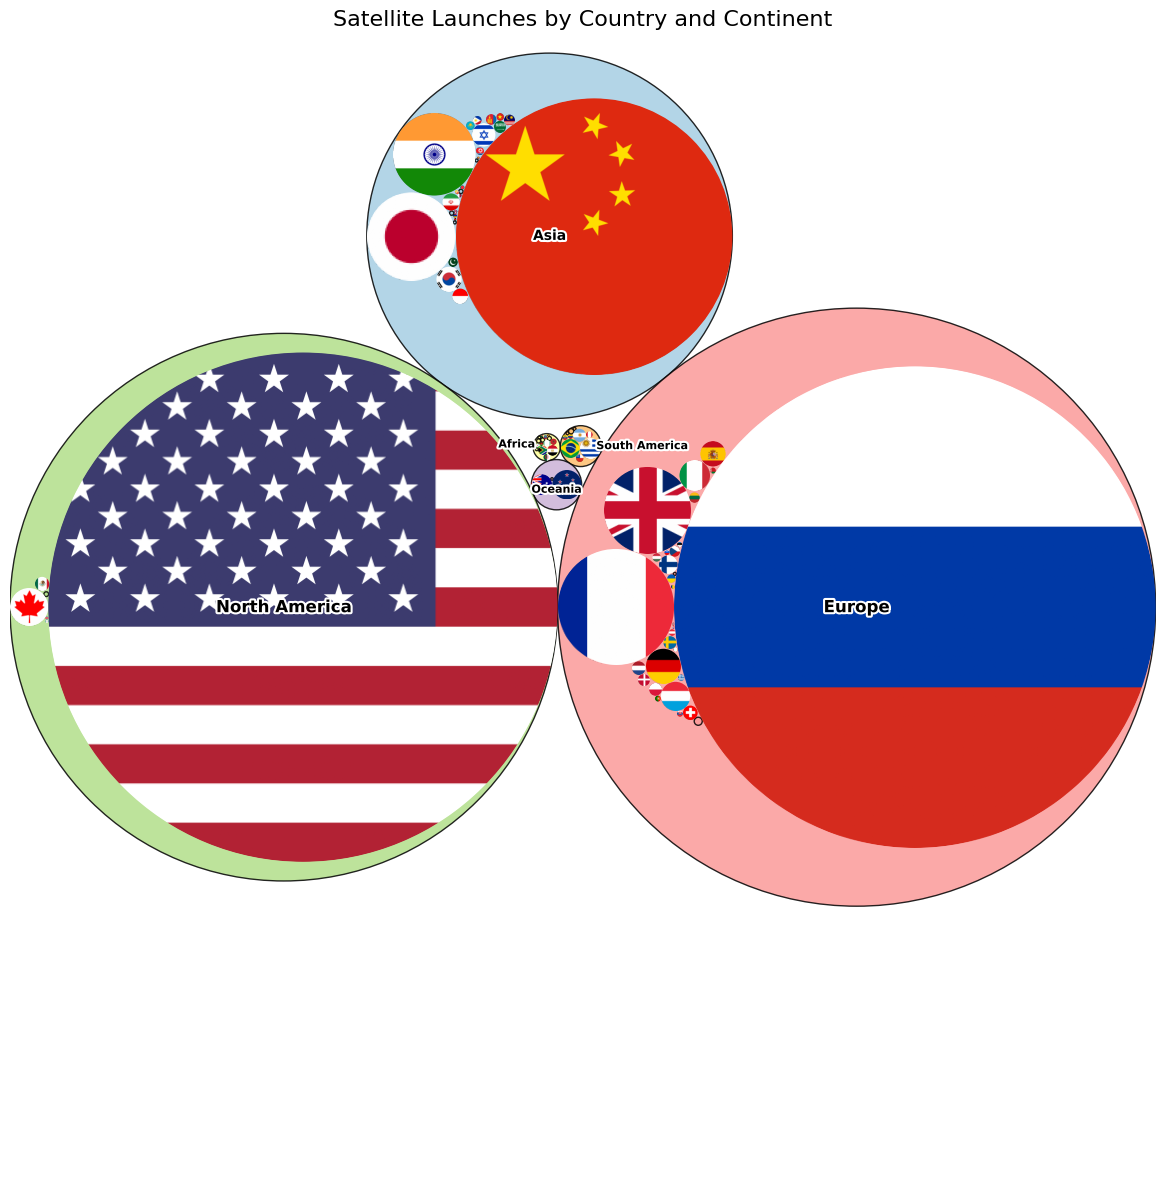

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import circlify
import pycountry
import matplotlib.patheffects as pe
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import os
import logging
import warnings
import ipywidgets as widgets
from IPython.display import display, clear_output

logging.getLogger('matplotlib.font_manager').disabled = True
warnings.filterwarnings("ignore", category=UserWarning, module='matplotlib.font_manager')


satcat = pd.read_csv("satcat.tsv", sep="\t", low_memory=False)

manual_country_map = {
    'UK': 'United Kingdom',
    'D': 'Germany',
    'E': 'Spain',
    'F': 'France',
    'I': 'Italy',
    'J': 'Japan',
    'L': 'Luxembourg',
    'P': 'Portugal',
    'S': 'Sweden',
    'SU': 'Russia',
    'CSFR': 'Czech Republic',
    'CSSR': 'Czech Republic',
    'HKUK': 'United Kingdom',
    'MYM': 'Malaysia',
    'BGN': 'Bulgaria',
    'CYM': 'United Kingdom',
}

code_to_name = {country.alpha_2: country.name for country in pycountry.countries}

def resolve_country(code):
    if code in manual_country_map:
        return manual_country_map[code]
    return code_to_name.get(code)

satcat['Country'] = satcat['State'].map(resolve_country)
satcat_clean = satcat.dropna(subset=['Country'])
launch_counts = satcat_clean['Country'].value_counts().to_dict()

if 'Russia' in launch_counts:
    launch_counts['Russian Federation'] = (
        launch_counts.get('Russian Federation', 0) + launch_counts['Russia']
    )
    del launch_counts['Russia']

pop_df = pd.read_csv("world_population_2023.csv")
pop_df['Country'] = pop_df['Country'].replace({
    'Russia': 'Russian Federation'
})
population_counts = dict(zip(pop_df['Country'], pop_df['Population']))

world = gpd.read_file("ne_110m_admin_0_countries.shp")
world = world[['ADMIN', 'CONTINENT']]
world.columns = ['Country', 'Continent']

corrections = {
    "United States of America": "United States",
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "North Korea": "Korea, Democratic People's Republic of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Vietnam": "Viet Nam",
    "Laos": "Lao People's Democratic Republic",
    "Bolivia": "Bolivia, Plurinational State of",
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Tanzania": "Tanzania, United Republic of",
    "Brunei": "Brunei Darussalam",
    "Moldova": "Moldova, Republic of",
}
world['Country'] = world['Country'].replace(corrections)

world.loc[world['Country'] == 'Russian Federation', 'Continent'] = 'Europe'

def normalize_country_name(name):
    name = name.lower()
    name = name.replace(",", "")
    name = name.replace("republic of", "")
    name = name.replace("plurinational state of", "")
    name = name.replace("islamic republic of", "")
    name = name.replace("democratic people's republic of", "")
    name = name.replace("people's democratic republic", "")
    name = name.replace("united republic of", "")
    name = name.replace("bolivarian republic of", "")
    name = name.replace(" ", "_")
    name = name.strip("_")
    return name

def load_flag(country_name):
    manual_map = {
        "Korea, Republic of": "south_korea.png",
        "Korea, Democratic People's Republic of": "north_korea.png",
        "Iran, Islamic Republic of": "iran.png",
        "Russia": "russia.png",
        "Russian Federation": "russia.png",
        "United States": "united_states.png",
        "United Kingdom": "united_kingdom.png"
    }

    if country_name in manual_map:
        path = f"flags/{manual_map[country_name]}"
        if os.path.exists(path):
            return mpimg.imread(path)

    normalized = normalize_country_name(country_name)
    path = f"flags/{normalized}.png"
    if os.path.exists(path):
        return mpimg.imread(path)

    return None

def draw_flag_circle(ax, img, x, y, r):
    extent = [x - r, x + r, y - r, y + r]
    im = ax.imshow(img, extent=extent, zorder=1)
    clip = Circle((x, y), r, transform=ax.transData)
    im.set_clip_path(clip)

def plot_circle_packing(data_mode='Satellite Launches'):
    clear_output(wait=True)
    display(dropdown)

    if data_mode == 'Satellite Launches':
        value_map = launch_counts
        title = "Satellite Launches by Country and Continent"
    else:
        value_map = population_counts
        title = "Population by Country and Continent"

    df = world.copy()
    df['Value'] = df['Country'].map(value_map)
    df = df.dropna(subset=['Value'])

    children = []
    for continent in df['Continent'].unique():
        d = df[df['Continent'] == continent]
        countries = [{'id': row['Country'], 'datum': row['Value']} for _, row in d.iterrows()]
        total = sum(c['datum'] for c in countries)
        children.append({'id': continent, 'datum': total, 'children': countries})

    nested_data = {'id': 'World', 'children': children}
    circles = circlify.circlify(
        nested_data['children'],
        show_enclosure=True,
        target_enclosure=circlify.Circle(x=0, y=0, r=1),
    )

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.axis('off')
    lim = max(abs(c.x) + c.r for c in circles)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    continent_colors = {
        'Asia': '#A6CEE3', 'North America': '#B2DF8A', 'Europe': '#FB9A99',
        'South America': '#FDBF6F', 'Oceania': '#CAB2D6', 'Africa': '#FFFF99'
    }

    for c in circles:
        if c.ex is None:
            continue
        x, y, r = c.x, c.y, c.r
        label = c.ex['id']
        level = c.level
        datum = c.ex.get('datum', 0)
        continent = None

        if level == 2:
            for cont in children:
                if any(ctry['id'] == label for ctry in cont['children']):
                    continent = cont['id']
                    break
        elif level == 1:
            continent = label

        facecolor = continent_colors.get(continent, '#dddddd')

        if level == 1:
            ax.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='black'))
            if data_mode == 'Satellite Launches':
                label_offsets = {
                    'Africa': (-r * 2.2, r * 0.2),
                    'Oceania': (0, -r * 0.2),
                    'South America': (r * 3, 0),
                }
                dx, dy = label_offsets.get(label, (0, 0))
            else:
                dx, dy = 0, 0
            font_size = 12 if r > 0.4 else (10 if r > 0.25 else 8)
            ax.text(x + dx, y + dy, label,
                    ha='center', va='center', fontsize=font_size, fontweight='bold',
                    path_effects=[pe.withStroke(linewidth=3, foreground="white")])
        elif level == 2:
            flag_img = load_flag(label)
            if flag_img is not None:
                draw_flag_circle(ax, flag_img, x, y, r)
                continue
            ax.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='black'))
            if datum >= 60:
                ax.text(x, y, f"{label}\n{int(datum)}",
                        ha='center', va='center', fontsize=6,
                        path_effects=[pe.withStroke(linewidth=2, foreground="white")])

    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

dropdown = widgets.Dropdown(
    options=['Satellite Launches', 'Population'],
    value='Satellite Launches',
    description='View:',
    style={'description_width': 'initial'}
)

display(dropdown)
plot_circle_packing(dropdown.value)
dropdown.observe(lambda change: plot_circle_packing(change['new']), names='value')

In [5]:
import pandas as pd
import plotly.graph_objects as go
import pycountry

satcat_data = pd.read_csv("satcat.tsv", sep="\t", low_memory=False)
satcat_data['Launch Year'] = pd.to_datetime(satcat_data['LDate'], errors='coerce').dt.year
satcat_data.loc[satcat_data['State'] == 'SU', 'State'] = 'RU'  

manual_country_map = {
    'UK': 'United Kingdom',
    'D': 'Germany',
    'E': 'Spain',
    'F': 'France',
    'I': 'Italy',
    'J': 'Japan',
    'L': 'Luxembourg',
    'P': 'Portugal',
    'S': 'Sweden',
    'SU': 'Russia',
    'CSFR': 'Czech Republic',
    'CSSR': 'Czech Republic',
    'HKUK': 'United Kingdom',
    'MYM': 'Malaysia',
    'BGN': 'Bulgaria',
    'CYM': 'United Kingdom',
}

country_map = {c.alpha_2: c.name for c in pycountry.countries}
country_map.update(manual_country_map)

satcat_data['Country'] = satcat_data['State'].map(country_map)
satcat_data_clean = satcat_data.dropna(subset=['Country', 'Launch Year'])

years = list(range(1957, int(satcat_data_clean['Launch Year'].max()) + 1))
countries = satcat_data_clean['Country'].unique()
grid = pd.MultiIndex.from_product([years, countries], names=['Launch Year', 'Country'])

launch_counts = satcat_data_clean.groupby(['Launch Year', 'Country']).size()
launches_by_year = launch_counts.reindex(grid, fill_value=0).reset_index(name='Launch_Count')
launches_by_year['Cumulative_Launches'] = launches_by_year.groupby('Country')['Launch_Count'].cumsum()

first_launch_years = launches_by_year[launches_by_year['Cumulative_Launches'] > 0].groupby('Country')['Launch Year'].min()
launches_by_year['First_Launch_Year'] = launches_by_year['Country'].map(first_launch_years)
filtered = launches_by_year[launches_by_year['Launch Year'] >= launches_by_year['First_Launch_Year']]
launches_trimmed = filtered.copy()

annotations_timeline = [
    (1957, "🛰 Sputnik 1: First satellite (USSR)", 1.13, 0.9, 1),
    (1961, "🚀 Cold War space race escalates", 0.5, 1.05, 3),
    (1970, "🇨🇳 First Chinese satellite: Dong Fang Hong 1", 1.16, 0.7, 3),
    (1980, "🇷🇺 USSR pulls ahead of USA in total launches", 1.15, 0.85, 3),
    (1998, "🇪🇬 Egypt launches first African satellite", 0.9, 0.68, 2),
    (2000, "🇨🇳 China surges in launches", 1.03, 0.65, 2),
    (2012, "🇪🇺 Mini-satellite boom: 4+ European nations join space", 0.6, 0.9, 4),
    (2015, "🛰 Commercial CubeSat boom begins", 0.5, 0.1, 3),
    (2020, "🚀 Starlink deployment begins (USA)", -0.05, 0.65, 3),
    (2022, "🌐 3,000+ Starlink satellites", -0.05, 0.75, 3),
    (2025, "📡 Starlink dominates LEO", 0.2, 0.6, 1)
]

years_sorted = sorted(launches_trimmed['Launch Year'].unique())
frame_annotations = {year: [] for year in years_sorted}
for start_year, text, x, y, duration in annotations_timeline:
    for offset in range(duration):
        y_frame = start_year + offset
        if y_frame in frame_annotations:
            frame_annotations[y_frame].append(
                dict(
                    text=text,
                    x=x, y=y,
                    xref="paper", yref="paper",
                    showarrow=False,
                    bgcolor="white",
                    bordercolor="black",
                    borderpad=4,
                    font=dict(size=13)
                )
            )

frames = []
for year in years_sorted:
    frame_data = launches_trimmed[launches_trimmed['Launch Year'] == year]
    frames.append(go.Frame(
        data=[go.Choropleth(
            locations=frame_data['Country'],
            locationmode='country names',
            z=frame_data['Cumulative_Launches'],
            colorscale='YlOrRd',
            zmin=0,
            zmax=launches_trimmed['Cumulative_Launches'].max(),
            marker_line_color='black',
            colorbar_title='Cumulative Launches'
        )],
        name=str(year),
        layout=go.Layout(annotations=frame_annotations.get(year, []))
    ))

initial_year = launches_trimmed['Launch Year'].min()
initial_data = launches_trimmed[launches_trimmed['Launch Year'] == initial_year]

fig = go.Figure(
    data=go.Choropleth(
        locations=initial_data['Country'],
        locationmode='country names',
        z=initial_data['Cumulative_Launches'],
        colorscale='YlOrRd',
        zmin=0,
        zmax=launches_trimmed['Cumulative_Launches'].max(),
        marker_line_color='black',
        colorbar_title='Cumulative Launches'
    ),
    frames=frames
)

fig.update_layout(
    title=f"Cumulative Satellite Launches by Country (Time-Lapse: 1957–{years[-1]})",
    geo=dict(
        showland=True,
        landcolor="lightgray",
        showocean=True,
        oceancolor="lightblue",
        showcoastlines=True,
        coastlinecolor="white"
    ),
    paper_bgcolor="white",
    font=dict(family="Arial", size=12),
    margin=dict(l=30, r=30, t=80, b=30),
    updatemenus=[dict(
        type="buttons",
        direction="right",
        x=0.5, y=-0.01,
        xanchor="center", yanchor="top",
        buttons=[
            dict(label="▶ Play", method="animate", args=[None, {
                "frame": {"duration": 500, "redraw": True},
                "fromcurrent": True
            }]),
            dict(label="⏸ Pause", method="animate", args=[[None], {
                "frame": {"duration": 0, "redraw": False},
                "mode": "immediate"
            }])
        ],
        pad={"r": 10, "t": 10},
        showactive=False,
        bgcolor="white",
        borderwidth=1
    )],
    sliders=[dict(
        active=0,
        yanchor="top",
        xanchor="left",
        currentvalue={
            "prefix": "Launch Year = ",
            "font": {"size": 17}  
        },
        pad={"t": 30},
        steps=[
            dict(method="animate", args=[[str(year)], {
                "mode": "immediate",
                "frame": {"duration": 500, "redraw": True},
                "transition": {"duration": 0}
            }], label=str(year)) for year in years_sorted
        ]
    )]
)

fig.show()

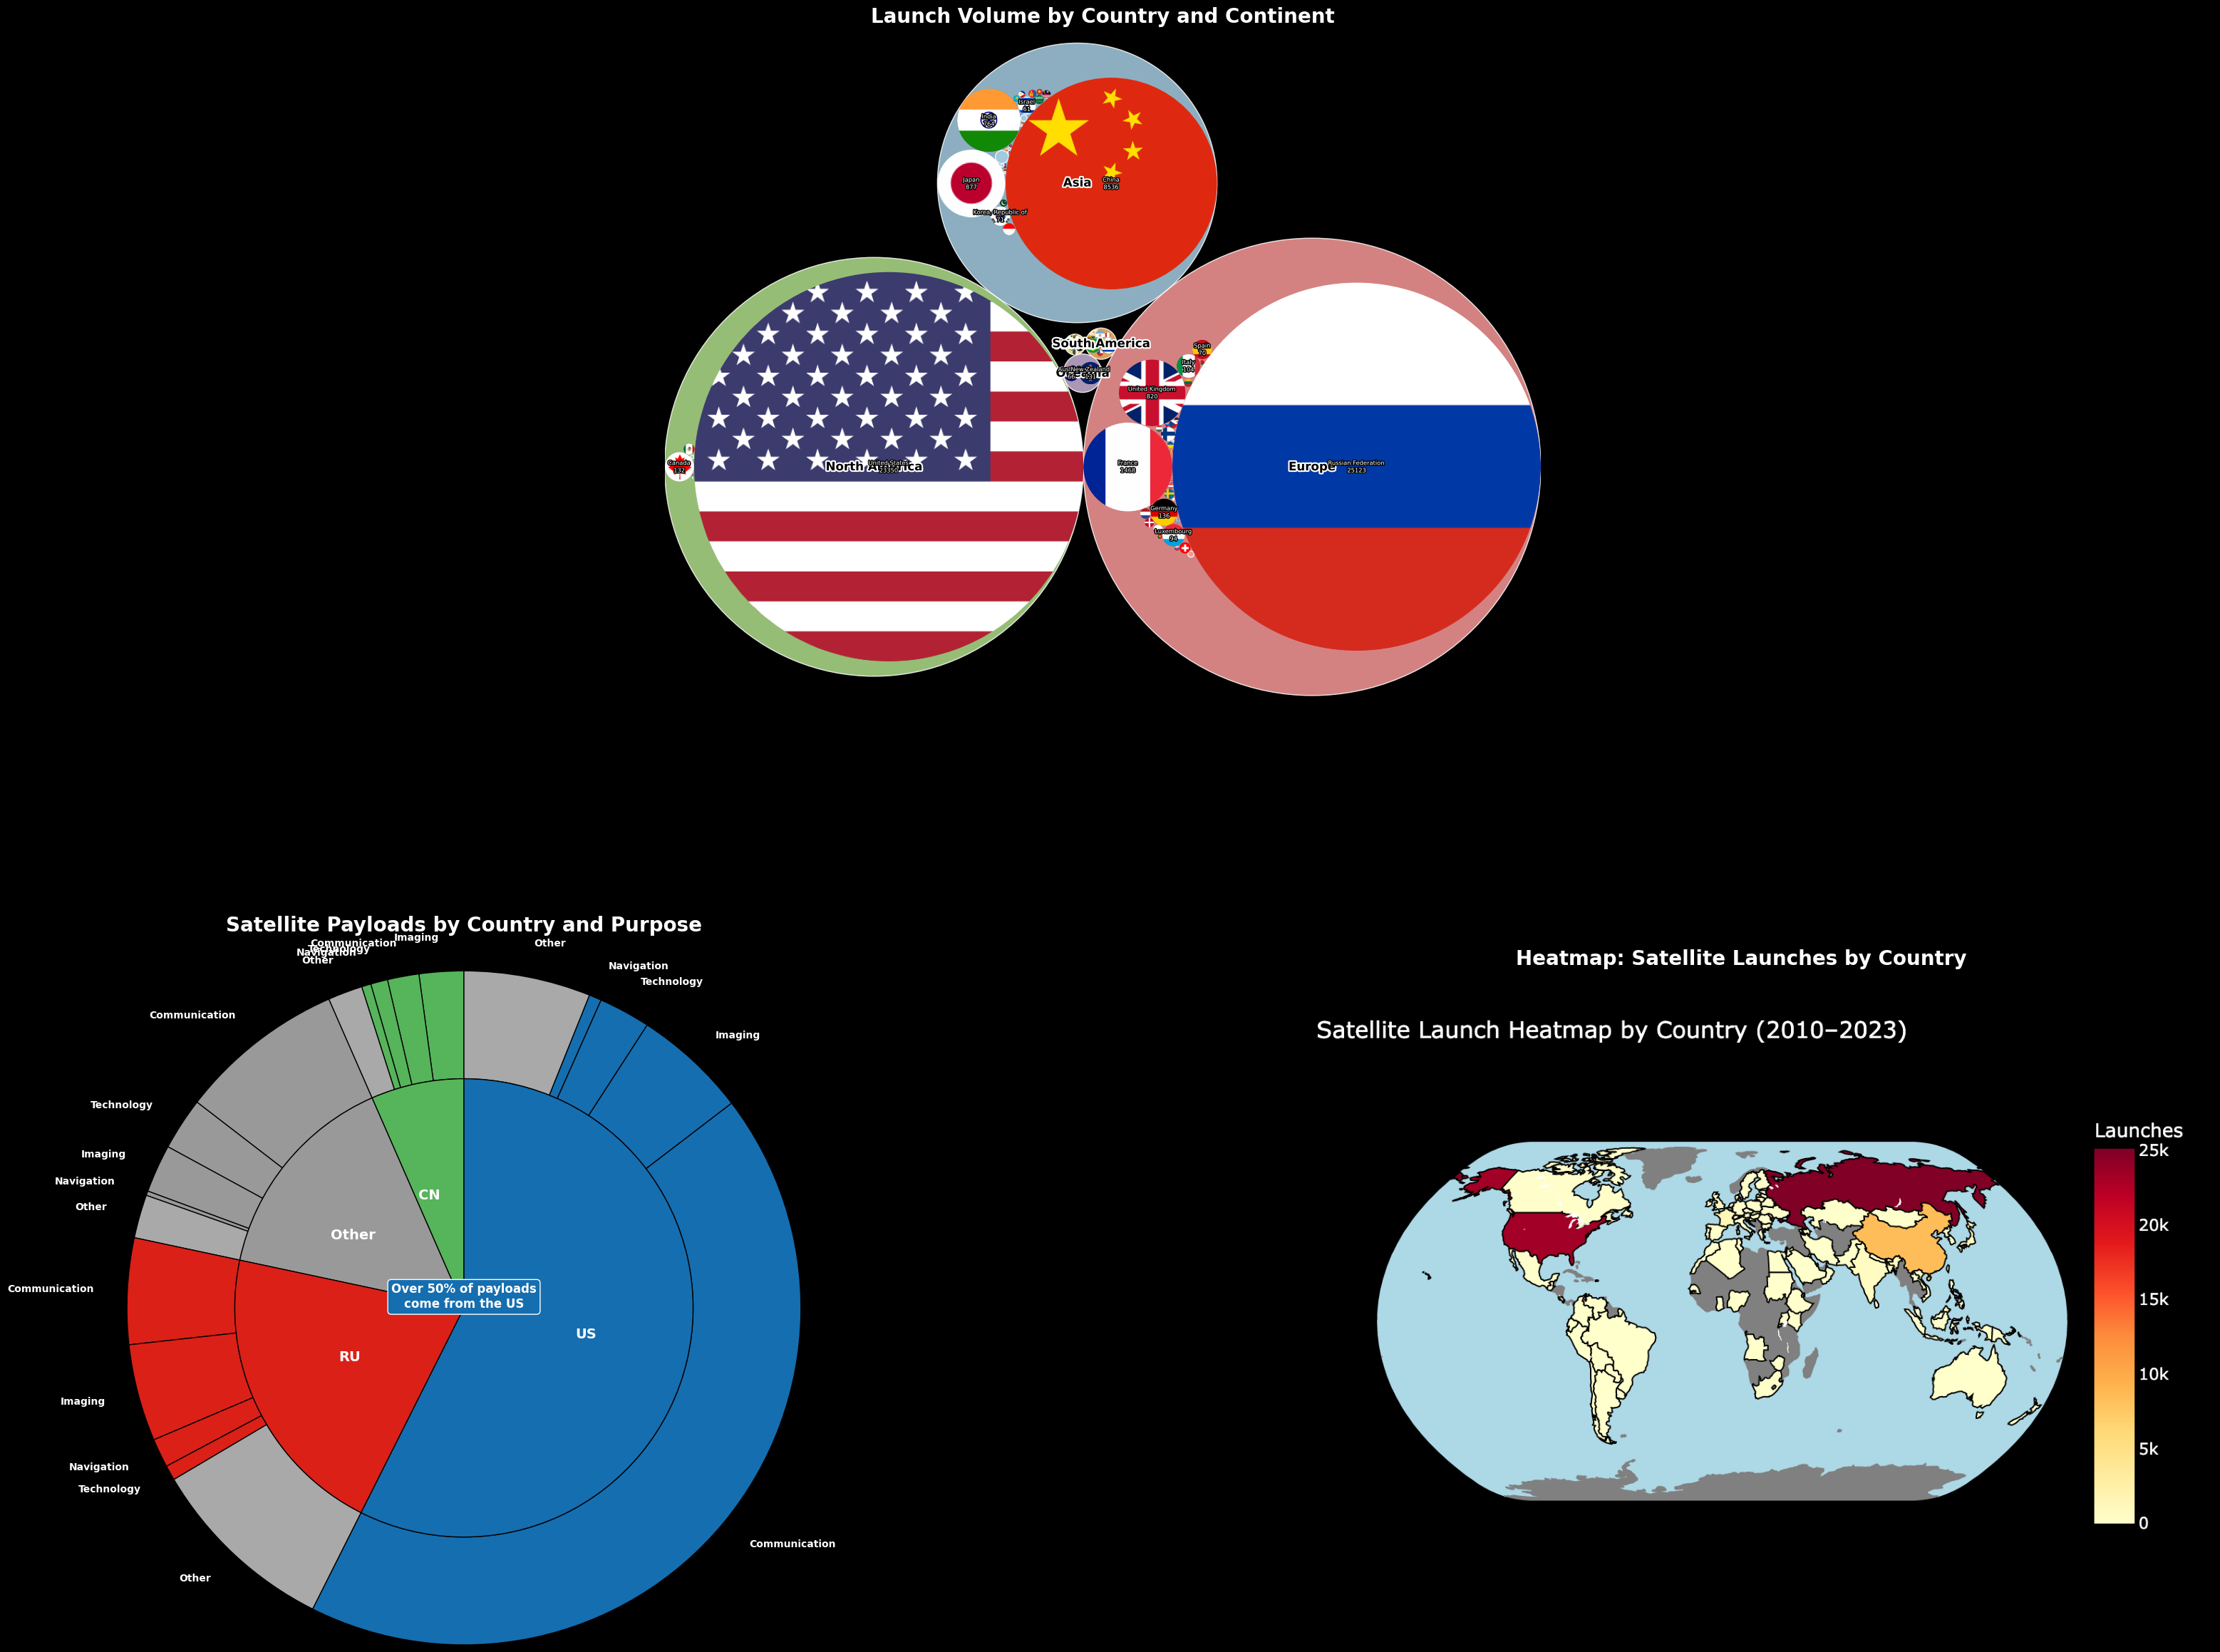

In [6]:
import os
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Circle
import matplotlib.image as mpimg
import circlify
import pycountry
from matplotlib.gridspec import GridSpec
import plotly.graph_objects as go

satcat = pd.read_csv("satcat.tsv", sep="\t", low_memory=False)
psatcat = pd.read_csv("psatcat.tsv", sep="\t", low_memory=False)
satcat.loc[satcat['State'] == 'SU', 'State'] = 'RU'

manual_country_map = {
    'UK': 'United Kingdom', 'D': 'Germany', 'E': 'Spain', 'F': 'France',
    'I': 'Italy', 'J': 'Japan', 'L': 'Luxembourg', 'P': 'Portugal',
    'S': 'Sweden', 'RU': 'Russia', 'CSFR': 'Czech Republic', 'CSSR': 'Czech Republic',
    'HKUK': 'United Kingdom', 'MYM': 'Malaysia', 'BGN': 'Bulgaria', 'CYM': 'United Kingdom',
    '-': 'Unknown'
}
code_to_name = {c.alpha_2: c.name for c in pycountry.countries}
code_to_name.update(manual_country_map)
satcat['Country'] = satcat['State'].map(code_to_name)
satcat_clean = satcat.dropna(subset=['Country'])

launch_counts = satcat_clean['Country'].value_counts().to_dict()
if 'Russia' in launch_counts:
    launch_counts['Russian Federation'] = launch_counts['Russia']
world = gpd.read_file("ne_110m_admin_0_countries.shp")
world = world[['ADMIN', 'CONTINENT']]
world.columns = ['Country', 'Continent']

corrections = {
    "United States of America": "United States",
    "Russia": "Russian Federation",
    "South Korea": "Korea, Republic of",
    "North Korea": "Korea, Democratic People's Republic of",
    "Iran": "Iran, Islamic Republic of",
    "Syria": "Syrian Arab Republic",
    "Vietnam": "Viet Nam",
    "Laos": "Lao People's Democratic Republic",
    "Bolivia": "Bolivia, Plurinational State of",
    "Venezuela": "Venezuela, Bolivarian Republic of",
    "Tanzania": "Tanzania, United Republic of",
    "Brunei": "Brunei Darussalam",
    "Moldova": "Moldova, Republic of",
}
world['Country'] = world['Country'].replace(corrections)
world.loc[world['Country'] == 'Russian Federation', 'Continent'] = 'Europe'
world['Launches'] = world['Country'].map(launch_counts)
world = world.dropna(subset=['Launches'])

children = []
for continent in world['Continent'].unique():
    df = world[world['Continent'] == continent]
    countries = [{'id': row['Country'], 'datum': row['Launches']} for _, row in df.iterrows()]
    total = sum(c['datum'] for c in countries)
    children.append({'id': continent, 'datum': total, 'children': countries})
nested_data = {'id': 'World', 'children': children}
circles = circlify.circlify(nested_data['children'], show_enclosure=True, target_enclosure=circlify.Circle(x=0, y=0, r=1))

df_sat = satcat[satcat['Type'].str.startswith('P', na=False)].copy()
df_cat = psatcat.copy()
df_sat['#JCAT'] = df_sat['#JCAT'].astype(str)
df_cat['#JCAT'] = df_cat['#JCAT'].astype(str)
merged_df = pd.merge(df_sat, df_cat[['#JCAT', 'Category']], on='#JCAT', how='left')
merged_df['State'] = merged_df['State'].replace({'SU': 'RU'})
merged_df = merged_df.dropna(subset=['Category'])

def simplify_category(cat):
    if 'COM' in cat: return 'Communication'
    elif 'IMG' in cat: return 'Imaging'
    elif 'NAV' in cat: return 'Navigation'
    elif 'TECH' in cat: return 'Technology'
    else: return 'Other'
merged_df['Category'] = merged_df['Category'].astype(str).apply(simplify_category)

top_countries = ['US', 'RU', 'CN']
merged_df['CountryGroup'] = merged_df['State'].apply(lambda x: x if x in top_countries else 'Other')
country_colors = {'US': '#156EAF', 'RU': '#DB2018', 'CN': '#56B45B', 'Other': '#999999'}
df_total = merged_df.groupby('CountryGroup').size().reset_index(name='Count')
df_sorted = merged_df.groupby(['CountryGroup', 'Category']).size().reset_index(name='Count')
df_sorted['sort_key'] = df_sorted['Category'].apply(lambda x: 1 if x == 'Other' else 0)
df_sorted = df_sorted.sort_values(by=['CountryGroup', 'sort_key', 'Count'], ascending=[True, True, False])

launch_counts_by_country = satcat_clean['Country'].value_counts().reset_index(name="Launch_Count")
launch_counts_by_country.columns = ['Country', 'Launch_Count']
fig_choropleth = go.Figure(data=go.Choropleth(
    locations=launch_counts_by_country['Country'],
    locationmode='country names',
    z=launch_counts_by_country['Launch_Count'],
    colorscale='YlOrRd',
    colorbar_title='Launches',
    marker_line_color='black',
))

fig_choropleth.update_layout(
    paper_bgcolor='black',
    plot_bgcolor='black',
    title_text="Satellite Launch Heatmap by Country (2010–2023)",
    title_font_color='white',
    font=dict(color='white'),
    geo=dict(
        bgcolor='black',
        showland=True, landcolor="gray",
        showocean=True, oceancolor="lightblue",
        showcoastlines=True, coastlinecolor='gray',
        showframe=False,
        projection_type="natural earth"
    ),
)

fig_choropleth.write_image("choropleth.png", scale=2)

fig = plt.figure(figsize=(36, 24), facecolor='black')

gs = GridSpec(2, 2, figure=fig, height_ratios=[1.3, 1])

ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')
lim = max(abs(c.x) + c.r for c in circles)
ax1.set_xlim(-lim, lim)
ax1.set_ylim(-lim, lim)
ax1.set_title("Launch Volume by Country and Continent", fontsize=20, weight='bold', color='white')

continent_colors = {
    'Asia': '#A6CEE3', 'North America': '#B2DF8A', 'Europe': '#FB9A99',
    'South America': '#FDBF6F', 'Oceania': '#CAB2D6', 'Africa': '#FFFF99'
}

def normalize_country_name(name):
    name = name.lower()
    for phrase in ["republic of", "plurinational state of", "islamic republic of", "democratic people's republic of",
                   "people's democratic republic", "united republic of", "bolivarian republic of"]:
        name = name.replace(phrase, "")
    return name.replace(",", "").replace(" ", "_").strip("_")

def load_flag(country_name):
    path = f"flags/{normalize_country_name(country_name)}.png"
    return mpimg.imread(path) if os.path.exists(path) else None

for c in circles:
    if c.ex is None:
        continue
    x, y, r = c.x, c.y, c.r
    label = c.ex['id']
    level = c.level
    datum = c.ex.get('datum', 0)
    continent = None
    if level == 2:
        for cont in children:
            if any(ctry['id'] == label for ctry in cont['children']):
                continent = cont['id']
                break
    elif level == 1:
        continent = label
    facecolor = continent_colors.get(continent, '#dddddd')
    if level == 1:
        ax1.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='white'))
        ax1.text(x, y, label, ha='center', va='center', fontsize=12, fontweight='bold',
                 color='black', path_effects=[pe.withStroke(linewidth=3, foreground="white")])
    elif level == 2:
        flag_img = load_flag(label)
        if flag_img is not None:
            extent = [x - r, x + r, y - r, y + r]
            im = ax1.imshow(flag_img, extent=extent, zorder=1)
            clip = Circle((x, y), r, transform=ax1.transData)
            im.set_clip_path(clip)
        else:
            ax1.add_patch(plt.Circle((x, y), r, alpha=0.85, facecolor=facecolor, edgecolor='white'))
        if datum >= 60:
            ax1.text(x, y, f"{label}\n{int(datum)}", ha='center', va='center', fontsize=6,
                     color='white', path_effects=[pe.withStroke(linewidth=2, foreground="black")])

ax2 = fig.add_subplot(gs[1, 0])
outer_colors = [
    '#A9A9A9' if cat == 'Other' else country_colors[group]
    for cat, group in zip(df_sorted['Category'], df_sorted['CountryGroup'])
]
ax2.pie(df_sorted['Count'], radius=1.25, colors=outer_colors, wedgeprops=dict(width=0.4, edgecolor='black'),
        startangle=90, labels=df_sorted['Category'], labeldistance=1.1,
        textprops=dict(fontsize=10, weight='bold', color='white'))
ax2.pie(df_total['Count'], radius=0.85, colors=[country_colors[g] for g in df_total['CountryGroup']],
        wedgeprops=dict(width=0.85, edgecolor='black'), startangle=90,
        labels=df_total['CountryGroup'], labeldistance=0.5,
        textprops=dict(color='white', fontsize=14, weight='bold'))
ax2.set_title("Satellite Payloads by Country and Purpose", pad=40, fontsize=20, weight='bold', color='white')
ax2.annotate('Over 50% of payloads\ncome from the US', xy=(0, 0), fontsize=12, weight='bold', color='white',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='white', facecolor='#156EAF'), ha='center')

ax3 = fig.add_subplot(gs[1, 1])
choropleth_img = mpimg.imread("choropleth.png")
ax3.imshow(choropleth_img)
ax3.axis('off')
ax3.set_title("Heatmap: Satellite Launches by Country", fontsize=20, weight='bold', color='white')

plt.tight_layout(rect=[0, 0, 1, 0.97])
fig.savefig("final_infographic_36x24_black.png", dpi=300, facecolor=fig.get_facecolor())
plt.show()




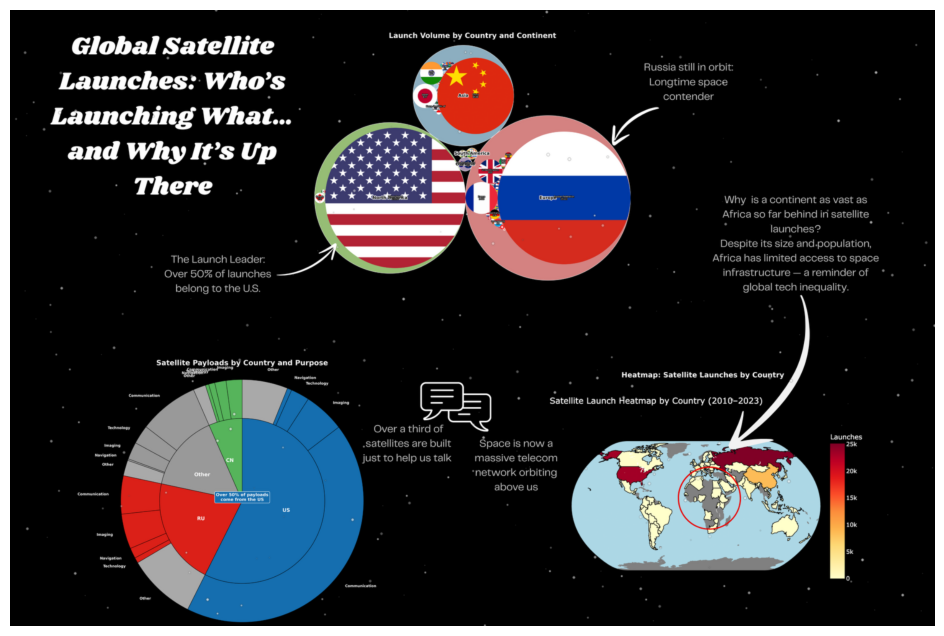

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("satellite_infographic.png")
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')  
plt.show()

#Used Image editor for the changes 